Manifold Learning with Isomap
=============================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour explores the Isomap algorithm for manifold learning.


The <http://waldron.stanford.edu/~isomap/ Isomap> algorithm is introduced in


_A Global Geometric Framework for Nonlinear Dimensionality Reduction,_
J. B. Tenenbaum, V. de Silva and J. C. Langford,
Science 290 (5500): 2319-2323, 22 December 2000.

In [1]:
using PyPlot
using NtToolBox
# using Autoreload

Graph Approximation of Manifolds
--------------------------------
Manifold learning consist in approximating the parameterization of a
manifold represented as a point cloud.


First we load a simple 3D point cloud, the famous Swiss Roll.


Number of points.

In [2]:
n = 500; #1000 points leads to very slow computation

Random position on the parameteric domain.

In [3]:
x = rand(2,n);

Mapping on the manifold.

In [4]:
v = 3*pi/2*(.1 + 2*x[1,:])
X  = zeros(3,n)
X[2,:] = 20*x[2,:]
X[1,:] = - cos(v).*v
X[3,:] = sin(v).*v;

Parameter for display.

In [5]:
ms = 200
elev = 20; azim = -110;

Display the point cloud.

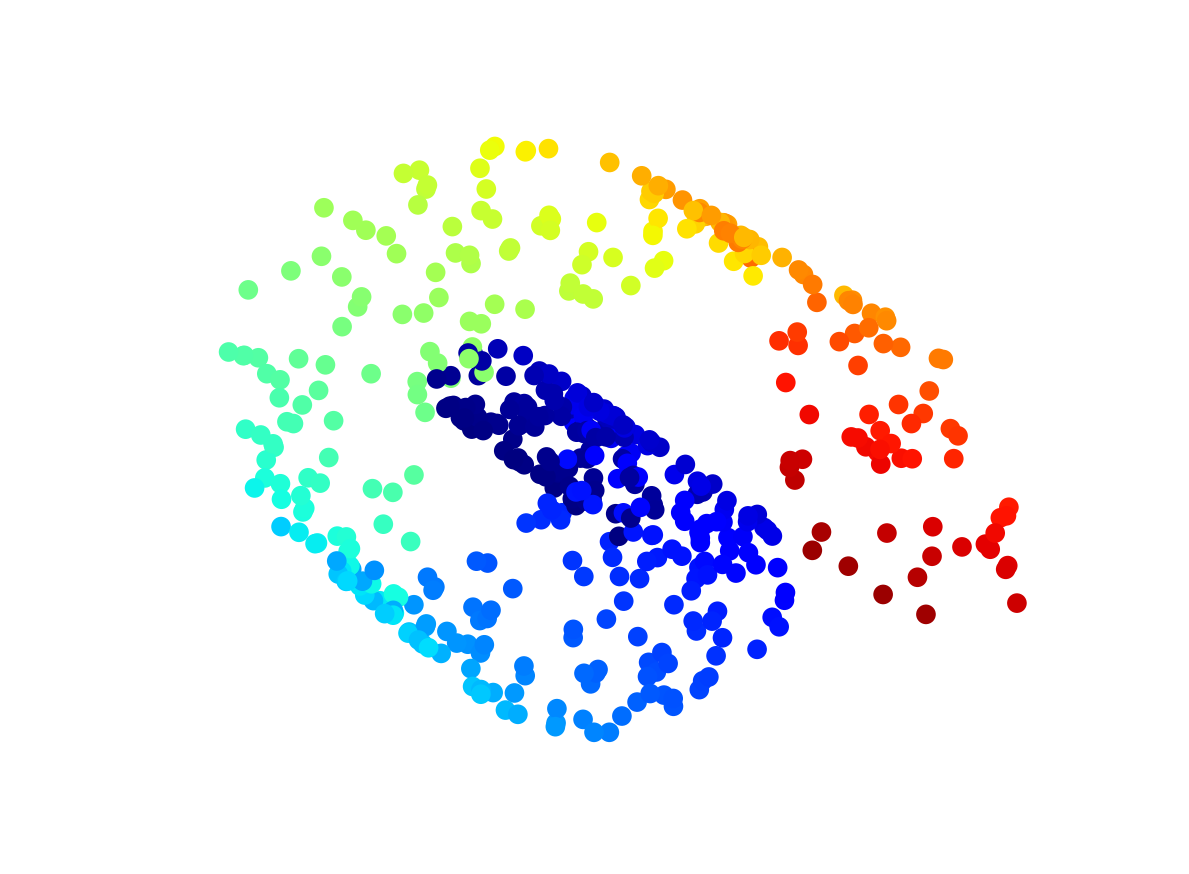

In [6]:
fig = figure(figsize=(15,11))
ax = gca(projection="3d")

#swiss roll
scatter3D(X[1,:], X[2,:], X[3,:], c=get_cmap("jet")((X[1,:].^2+X[3,:].^2)/100), s=ms, lw=0, alpha=1)

#params
xlim(minimum(X[1,:]),maximum(X[1,:]))
ylim(minimum(X[2,:]),maximum(X[2,:]))
zlim(minimum(X[3,:]),maximum(X[3,:]))
axis("off")
ax[:view_init](elev, azim)

Compute the pairwise Euclidean distance matrix.

In [7]:
D1 = repeat(sum(X.^2, 1), outer=(n,1))
D1 = D1 + D1' - 2*X'*X
D1[D1.<0] = NaN
D1=sqrt(D1);

Number of NN for the graph.

In [8]:
k = 6;

Compute the k-NN connectivity.

In [9]:
DNN, NN = zeros(size(D1)), zeros(size(D1))
for i in 1:size(D1,2)
    DNN[i,:], NN[i,:] = sort(D1[i,:]), sortperm(D1[i,:])
end
NN = Int.(NN[:,2:k+1])
DNN = DNN[:,2:k+1];

Adjacency matrix, and weighted adjacency.

In [10]:
B = repeat((1:n)', outer=(k,1))
A = sparse(vec(B), vec(NN'), ones(k*n));

Weighted adjacency (the metric on the graph).

In [11]:
W = sparse(vec(B),vec(NN'), vec(DNN'));

Display the graph.

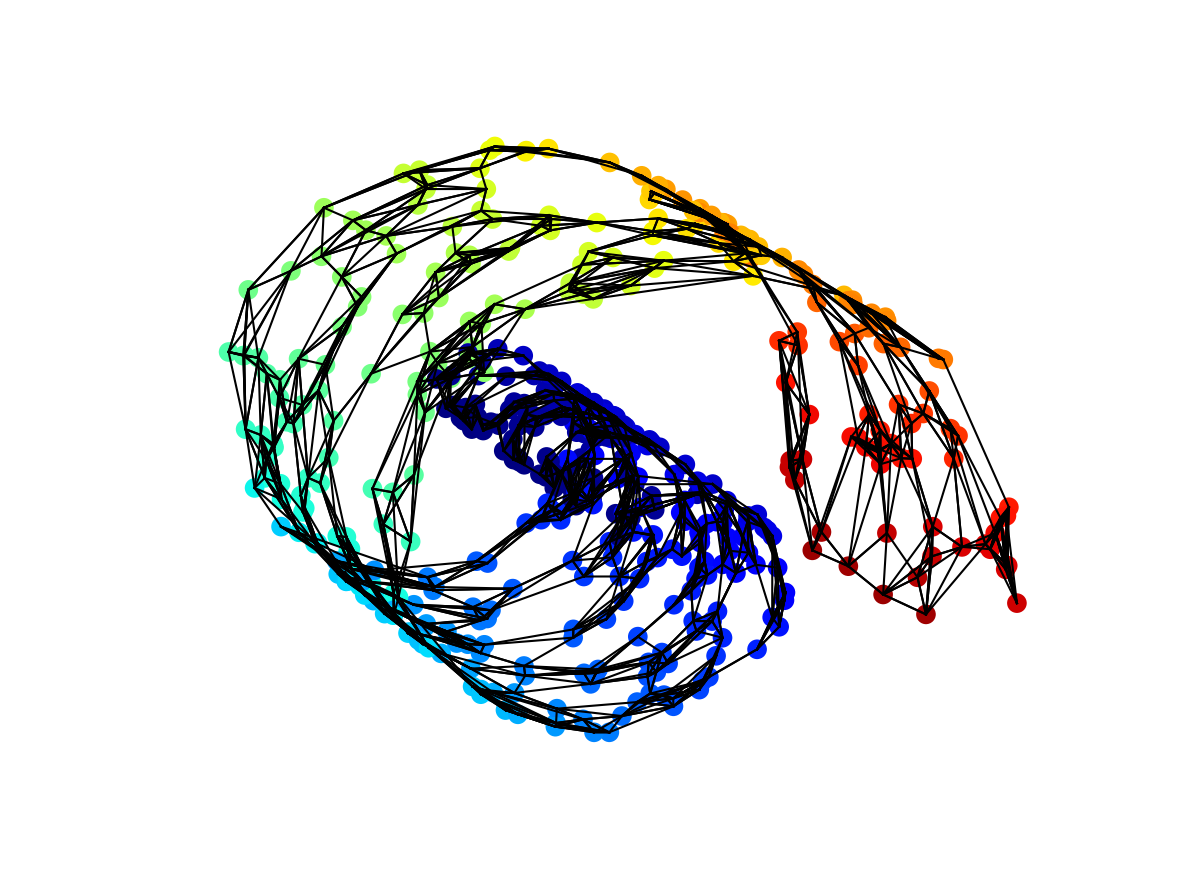

In [12]:
fig = figure(figsize=(15,11))
ax = gca(projection="3d")

#swiss roll
scatter3D(X[1,:], X[2,:], X[3,:], c=get_cmap("jet")((X[1,:].^2+X[3,:].^2)/100), s=ms, lw=0, alpha=1)

#graph
(I,J) = findn(A)
#(I,J) = (vec(B), vec(NN))
xx = hcat(X[1,I],X[1,J])
yy = hcat(X[2,I],X[2,J])
zz = hcat(X[3,I],X[3,J])

for i in 1:length(I)
    plot3D(xx[i,:], yy[i,:], zz[i,:], color="black")
end
    
#params
xlim(minimum(X[1,:]),maximum(X[1,:]))
ylim(minimum(X[2,:]),maximum(X[2,:]))
zlim(minimum(X[3,:]),maximum(X[3,:]))
axis("off")
ax[:view_init](elev, azim)

Floyd Algorithm to Compute Pairwise Geodesic Distances
------------------------------------------------------
A simple algorithm to compute the geodesic distances between all pairs of
points on a graph is Floyd iterative algorithm. Its complexity is
$\mathcal O(n^3)$ where $n$ is the number of points. It is thus quite slow for
sparse graph, where Dijkstra runs in $\mathcal O(n^2\log(n))$.


Floyd algorithm iterates the following update rule, for $k=1,\dots,n$


$D(i,j) \leftarrow \min(D(i,j), D(i,k)+D(k,j))$,


with the initialization $D(i,j)=W(i,j)$ if $W(i,j)>0$, and
$D(i,j)=Inf$ if $W(i,j)=0$.


Make the graph symmetric.

In [13]:
#W = readdlm("W.txt")
D = full(W)
D = (D + D')/2.;

Initialize the matrix.

In [14]:
D[D .== 0] = Inf;

Add connexion between a point and itself.

In [15]:
D = D - diagm(diag(D))
D[isnan(D)] = Inf;

__Exercise 1__

Implement the Floyd algorithm to compute the full distance matrix
$D$, where $D(i,j)$ is the geodesic distance between

In [ ]:
include("NtSolutions/shapes_7_isomap/exo1.jl")

In [ ]:
## Insert your code here.

Find index of vertices that are not connected to the main manifold.

In [ ]:
Iremove = find(D[:,1].==Inf);

Remove Inf remaining values (disconnected components).

In [ ]:
D[D .== Inf] = 0;

Isomap with Classical Multidimensional Scaling
----------------------------------------------
Isomap perform the dimensionality reduction by applying multidimensional
scaling.


Please refer to the tours on Bending Invariant for detail on
Classical MDS (strain minimization).

__Exercise 2__

Perform classical MDS to compute the 2D flattening.

In [ ]:
include("NtSolutions/shapes_7_isomap/exo2.jl");

Redess the points using the two leading eigenvectors of the covariance
matrix (PCA correction).

In [ ]:
(L,U) = eig(Xstrain*Xstrain' / n);
Xstrain1 = U'*Xstrain;

Remove problematic points.

In [ ]:
Xstrain1[:,Iremove] = Inf;

Display the final result of the dimensionality reduction.

In [ ]:
#plot size
figure(figsize = (15,6))

#plot points
scatter(Xstrain1[2,:], Xstrain1[1,:], c=get_cmap("jet")((X[1,:].^2+X[3,:].^2)/100), s=ms, lw=0, alpha=1)

#plot vertices
(I,J) = findn(A)
xx = hcat(Xstrain1[2,I], Xstrain1[2,J])
yy = hcat(Xstrain1[1,I], Xstrain1[1,J])

for i in 1:length(I)
    plot(xx[i,:], yy[i,:], color="black")
end

#params
xlim(minimum(Xstrain1[2,:]-1),maximum(Xstrain1[2,:])+1)
ylim(minimum(Xstrain1[1,:]-1),maximum(Xstrain1[1,:])+1)
axis("off");

For comparison, the ideal locations on the parameter domain.

In [ ]:
Y = [v'; X[2,:]']
Y[1,:] = rescale(Y[1,:], minimum(Xstrain[1,:]), maximum(Xstrain[1,:]))
Y[2,:] = rescale(Y[2,:], minimum(Xstrain[2,:]), maximum(Xstrain[2,:]));

Display the ideal graph on the reduced parameter domain.

In [ ]:
#plot size
figure(figsize = (15,6))

#plot points
scatter(Y[1,:], Y[2,:], c=get_cmap("jet")((X[1,:].^2+X[3,:].^2)/100), s=ms, lw=0, alpha=1)

#plot vertices
(I,J) = findn(A)
xx = hcat(Y[1,I],Y[1,J])
yy = hcat(Y[2,I],Y[2,J])

for i in 1:length(I)
    plot(xx[i,:], yy[i,:], color="black")
end 

#params
axis("off")
xlim(minimum(Y[1,:]-1), maximum(Y[1,:])+1)
ylim(minimum(Y[2,:]-1), maximum(Y[2,:])+1);

Isomap with SMACOF Multidimensional Scaling
-------------------------------------------
It is possible to use SMACOF instead of classical scaling.


Please refers to the tours on Bending Invariant for detail on both
Classical MDS (strain minimization) and SMACOF MDS (stress minimization).

__Exercise 3__

Perform stress minimization MDS using SMACOF to compute the 2D flattening.

In [ ]:
include("NtSolutions/shapes_7_isomap/exo3.jl")

In [ ]:
## Insert your code here.

Plot stress evolution during minimization.

In [ ]:
figure(figsize=(10,7))
plot(stress, ".-");

Compute the main direction of the point clouds.

In [ ]:
(L,U)=eig(Xstress*Xstress' / n)
(L,I) = (sort(L), sortperm(L))
U = U[:,I[2:3]];

Project the points on the two leading eigenvectors of the covariance
matrix (PCA final projection).

In [ ]:
Xstress1 = U'*Xstress;

Remove problematic points.

In [ ]:
Xstress1[:,Iremove] = Inf;

Display the final result of the dimensionality reduction.

In [ ]:
#plot size
figure(figsize = (15,6))

#plot points
scatter(Xstress1[2,:], Xstress1[1,:], c=get_cmap("jet")((X[1,:].^2+X[3,:].^2)/100), s=ms, lw=0, alpha=1)

#plot vertices
(I,J) = findn(A)
xx = [Xstress1[2,I] Xstress1[2,J]]
yy = [Xstress1[1,I] Xstress1[1,J]]

for i in 1:length(I)
    plot(xx[i,:], yy[i,:], color="black")
end

#params
axis("off")
xlim(minimum(Xstress1[2,:]-1),maximum(Xstress1[2,:])+1)
ylim(minimum(Xstress1[1,:]-1),maximum(Xstress1[1,:])+1);